# Thalamus subregions

This notebook contains many pieces related to thalamus subregions.

It has the subregions splits for explained variance, the spatial smoothness analysis.

Additionally, multiple reviewer figures were generated here.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import VideoAnalysisUtils.functions as func
import VideoAnalysisUtils.plotting_utils as plt_utils

In [2]:
figfolder = '../figs/thalamus/'
datafolder = '../data/'

os.makedirs(os.path.abspath(figfolder), exist_ok=True)

## Load data

In [3]:
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)


#r2_new = pickle.load(open(datafolder + 'r2_data_dict_smallwindows_v3.pkl', 'rb'))
r2_new = pickle.load(open(datafolder + 'final/r2_embed_cv_timeshift.pkl', 'rb'))


ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']
timeshifts = np.arange(-30,32,2, dtype = int)

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [4]:
thalamus_use_nuclei = [
    #'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    #'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    #'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    #'Paraventricular nucleus of the thalamus', #PVN
    #'Reticular nucleus of the thalamus', #RT
    #'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posterior complex of the thalamus', #VPN
]

short_names = [
    #'AN',
    'CN',
    'MD',
    #'MGN',
    'PC',
    #'PF',
    'PO',
    #'PVN',
    #'RT',
    #'SMN',
    'VAL',
    'VM',
    'VP',
]

short_names_correct_allen = [
    #'AM',
    'CM',
    'MD',
    #'MG',
    'PCN',
    #'PF',
    'PO',
    #'PVT',
    #'RT',
    #'SMT',
    'VAL',
    'VM',
    'VP',    
]

In [5]:
r2_threshold = 0.01
fr_threshold = 2
n_threshold = 100

epoch = 'response'
r2_method = 'new'

thalamus_inds = func.get_inds_for_list_of_regions(thalamus_use_nuclei, df, ccf_labels, alm_inds)

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2 > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

inds = {}
n_neurons = []
i = 0
use_short_names = []
for k,v in thalamus_inds.items():
    _this_inds = np.intersect1d(v, threshold_inds)
    if _this_inds.shape[0] > n_threshold:
        inds[k] = _this_inds
        n_neurons.append(_this_inds.shape[0])
        use_short_names.append(short_names_correct_allen[i])
    i += 1




In [6]:
n_neurons

[116, 1142, 271, 612, 463, 223, 662]

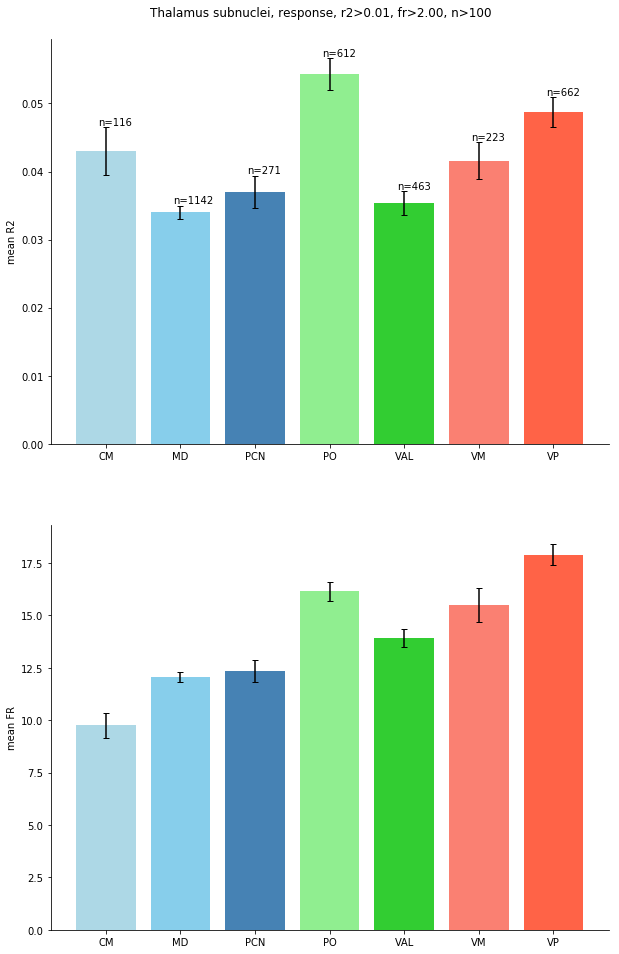

In [7]:
f = plt.figure(figsize=(10,15))

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]


ax_bar = f.add_subplot(2,1,1)

f.suptitle('Thalamus subnuclei, %s, r2>%0.2f, fr>%0.2f, n>%d'%(epoch, r2_threshold, fr_threshold, n_threshold))

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

m, sem = func.get_mean_and_sem_for_subregions(r2, inds, list(inds.keys()))
plt.bar(np.arange(0,len(m)), 
            m, yerr = sem, alpha = 1., color = cc, 
            capsize = 3, width=0.8, label = epoch)

for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
#ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean R2')


ax_bar = f.add_subplot(2,1,2)

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, inds, list(inds.keys()))
plt.bar(np.arange(0,len(m)), 
            m_fr, yerr = sem_fr, alpha = 1., color = cc, 
            capsize = 3, width=0.8, label = epoch)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
#ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean FR')

plt.subplots_adjust(top = 0.95)
#plt.savefig(figfolder + 'thalamus_subnuclei_%s_r2%0.2f_fr%0.2f_n%d.png'%(epoch, r2_threshold, fr_threshold, n_threshold))


## Nearest neightbor analysis

making sure that the data matches up with what we have in the final figure.

In [8]:
fig4 = plt_utils.Figure4()
fig4.load_data()

r2 = fig4.r2_data['5_0']['response_r2']
inds, short_names = fig4.get_thalamus_nuclei_inds()

In [9]:
# Generate nearest neighbor distributions
r2_diff_nn_dict = {}
for k, v in inds.items():
    r2_diff_nn_dict[k] = func.get_NN_r2_dist(r2, ccf_coords, v)

r2_diff_nn_dict['combined'] = np.concatenate(list(r2_diff_nn_dict.values()))
all_thalamus_inds = np.concatenate(list(inds.values()))
fr_inds = np.where(fig4.r2_data['5_0']['response_fr'] > 2)[0]
all_thalamus_inds = func.get_single_area_inds('Thalamus', df, ccf_labels, alm_inds)
threshold_inds = np.where(r2 > 0.01)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
all_thalamus_inds = np.intersect1d(all_thalamus_inds, threshold_inds)

r2_diff_nn_dict['together'] = func.get_NN_r2_dist(r2, ccf_coords, all_thalamus_inds)

In [10]:
sorted_combined = np.sort(r2_diff_nn_dict['combined'])
sorted_together = np.sort(r2_diff_nn_dict['together'])
cdf_combined = np.arange(0, len(sorted_combined)) / len(sorted_combined)
cdf_together = np.arange(0, len(sorted_together)) / len(sorted_together)

In [11]:
from scipy.interpolate import interp1d
def cdf_interpolate(x, y, x_new):
    f = interp1d(x, y, kind = 'previous')
    return f(x_new)

possible_x = np.concatenate((sorted_combined, sorted_together))

possible_x = np.sort(possible_x)
possible_x = possible_x[possible_x <= np.max(sorted_combined)]
possible_x = possible_x[possible_x <= np.max(sorted_together)]

max_diff = 0
x_max = 0

for xx in possible_x:
    cdf_combined_interp = cdf_interpolate(sorted_combined, cdf_combined, xx)
    cdf_together_interp = cdf_interpolate(sorted_together, cdf_together, xx)
    if np.abs(cdf_combined_interp - cdf_together_interp) > max_diff:
        max_diff = np.abs(cdf_combined_interp - cdf_together_interp)
        x_max = xx

In [12]:
print('max_diff', max_diff)
print('x_max', x_max)

max_diff 0.019414357771624702
x_max 0.038076463705019555


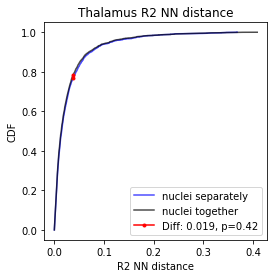

In [29]:
f = plt.figure(figsize=(4,4))
plt.plot(sorted_combined, cdf_combined,'b-', label = 'nuclei separately', alpha = 0.7)
plt.plot(sorted_together, cdf_together,'k-', label = 'nuclei together', alpha = .7)
plt.plot([x_max, x_max],
         [cdf_interpolate(sorted_combined, cdf_combined, x_max),
          cdf_interpolate(sorted_together,cdf_together,x_max)], 'r.-',label = 'Diff: %0.3f, p=%.2f'%(ks,p))
plt.legend()
plt.xlabel('R2 NN distance')
plt.ylabel('CDF')
plt.title('Thalamus R2 NN distance')
plt.savefig('../figs/supplementary_figs/thalamus_r2_nn_nuclei_separate_vs_together.png', dpi = 300)

In [21]:
ks, p = stats.ks_2samp(r2_diff_nn_dict['combined'], r2_diff_nn_dict['together'])
print('KS', ks, p)

KS 0.019334170126836678 0.4160632036840013


In [16]:
N_shuffle = 1000
np.random.seed(0)

# Generate nearest neighbor distributions
r2_diff_nn_dict = {}
for k, v in inds.items():
    r2_diff_nn_dict[k] = func.get_NN_r2_dist(r2, ccf_coords, v)

r2_diff_nn_dict['combined'] = np.concatenate(list(r2_diff_nn_dict.values()))

subnuclei_shuffle_r2_diffs = []
subnuclei_separate_shuffle_r2 = {}
for k, v in inds.items():
    subnuclei_separate_shuffle_r2[k] = []
    for i in range(N_shuffle):
        shuffle_inds = np.random.permutation(v)
        r2_shuffle = r2[shuffle_inds]
        r2_diffs = func.get_NN_r2_dist(r2_shuffle, ccf_coords[v], None)
        subnuclei_shuffle_r2_diffs.append(r2_diffs)
        subnuclei_separate_shuffle_r2[k].append(r2_diffs)

subnuclei_separate_shuffle_r2['combined'] = \
    [np.concatenate([subnuclei_separate_shuffle_r2[k][i] for k in inds.keys()]) 
     for i in range(N_shuffle)]

In [17]:
fname = 'nn_and_shuffle_r2_thalamus_subnuclei_new.pkl'
save_dict = {'subnuclei_separate_nn_r2': r2_diff_nn_dict,
             'subnuclei_separate_shuffle_r2': subnuclei_separate_shuffle_r2}
pickle.dump(save_dict, open(datafolder + fname, 'wb'))


In [18]:
nn_auc = {}
shuffle_auc = {}
auc_diff = {}
p_values = {}

for k,v in r2_diff_nn_dict.items():
    nn_sorted = np.sort(v)
    max_nn_r2 = nn_sorted[-1]
    nn_cdf = np.linspace(0,1,nn_sorted.shape[0])
    nn_auc[k] = func.calculate_auc(nn_sorted, nn_cdf)

    auc_diff[k] = []
    for i in range(N_shuffle):
        shuffle_sorted = np.sort(subnuclei_separate_shuffle_r2[k][i])
        shuffle_cdf = np.linspace(0,1, shuffle_sorted.shape[0])
        max_shuffle_r2 = shuffle_sorted[-1]

        if max_shuffle_r2 > max_nn_r2:
            _nn_sorted = np.append(nn_sorted,[max_shuffle_r2])
            _nn_cdf = np.append(nn_cdf, [1])
            _shuffle_sorted = shuffle_sorted
            _shuffle_cdf = shuffle_cdf

        else:
            _nn_sorted = nn_sorted
            _nn_cdf = nn_cdf
            _shuffle_sorted = np.append(shuffle_sorted,[max_nn_r2])
            _shuffle_cdf = np.append(shuffle_cdf, [1])

        auc_diff[k].append(func.calculate_auc(_nn_sorted, _nn_cdf) - func.calculate_auc(_shuffle_sorted, _shuffle_cdf))

    p_values[k] = np.sum(np.array(auc_diff[k]) <= 0) / N_shuffle

p_values


{'Central nucleus': 0.002,
 'Mediodorsal nucleus of thalamus': 0.0,
 'Paracentral nucleus': 0.0,
 'Posterior complex of the thalamus': 0.0,
 'Ventral anterior-lateral complex of the thalamus': 0.197,
 'Ventral medial nucleus of the thalamus': 0.0,
 'Ventral posterior complex of the thalamus': 0.0,
 'combined': 0.0}

In [19]:
print(p_values['combined'])

0.0


In [38]:
def plot_nn_and_shuffle_curves(ax, nn_r2, shuffle_r2, 
                               titlestr = "Thalamus nearest neighbor R2 analysis",
                               xlabel = 'R2 difference to nearest neighbor',
                               ylabel = 'Cumulative fraction',
                               auc_diff = None, p_value = None):
    nn_sorted = np.sort(nn_r2)
    nn_cdf = np.linspace(0,1,nn_sorted.shape[0])
    max_nn_r2 = nn_sorted[-1]

    shuffle_sorted = np.sort(shuffle_r2)
    shuffle_cdf = np.linspace(0,1, shuffle_sorted.shape[0])
    max_shuffle_r2 = shuffle_sorted[-1]

    if ax is None:
        f = plt.figure(figsize=(10,8))
        ax = f.add_subplot(1,1,1)
    
    if max_shuffle_r2 > max_nn_r2:
        _nn_sorted = np.append(nn_sorted,[max_shuffle_r2])
        _nn_cdf = np.append(nn_cdf, [1])
        _shuffle_sorted = shuffle_sorted
        _shuffle_cdf = shuffle_cdf

    else:
        _nn_sorted = nn_sorted
        _nn_cdf = nn_cdf
        _shuffle_sorted = np.append(shuffle_sorted,[max_nn_r2])
        _shuffle_cdf = np.append(shuffle_cdf, [1])

    ax.plot(_nn_sorted, _nn_cdf, '-', c = 'b', alpha = 0.9, lw = 2, label = 'nearest neighbor')
    ax.plot(_shuffle_sorted, _shuffle_cdf, '-', c = 'gray', alpha = 0.9, lw = 3, label = 'shuffled')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(titlestr)
    if auc_diff is not None and p_value is not None:
        ax.plot([],[],' ',label='auc_diff=%0.3f'%auc_diff)
        ax.plot([],[],' ',label='p=%0.3f'%p_value)
    ax.legend()
    


#### Reviewer figure for separate subnuclei

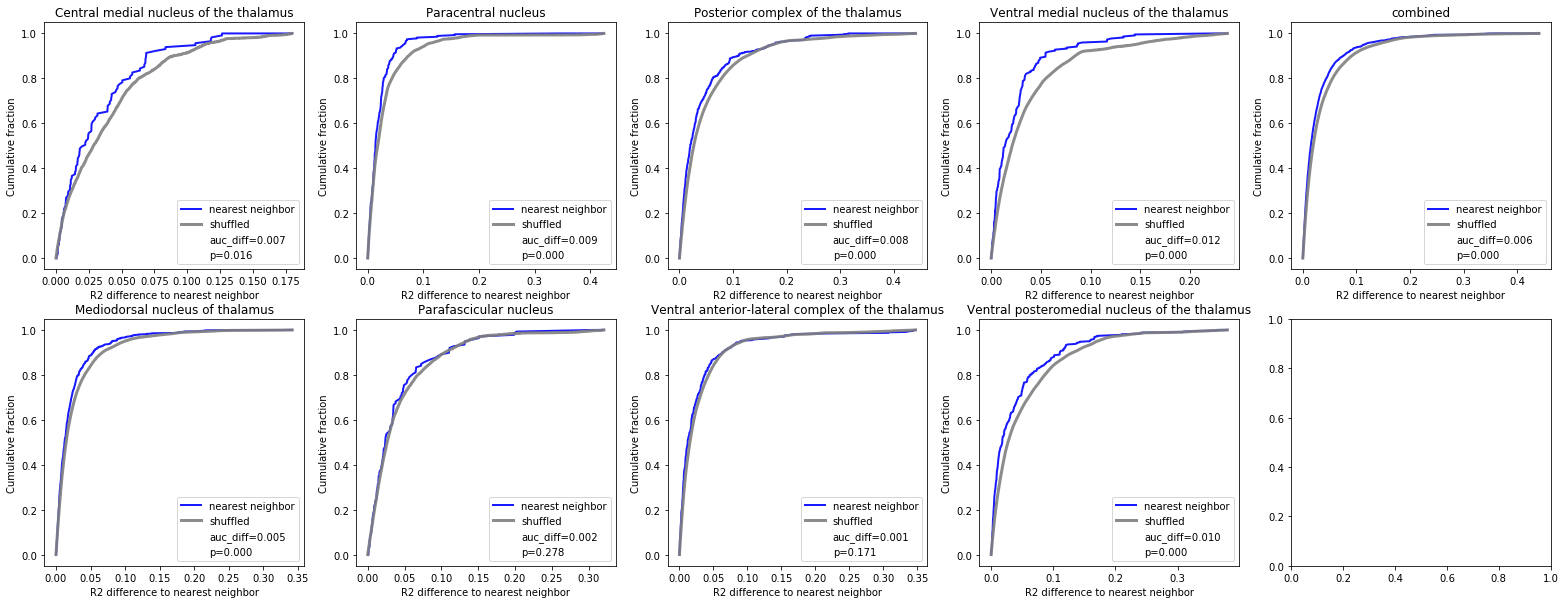

In [32]:
subregions = list(inds.keys()) + ['combined']
N_plots = len(subregions)
f, ax = plt.subplots(2, (N_plots+1)//2, figsize=(3 * N_plots, 10))


for i in range(len(subregions)):
    plot_nn_and_shuffle_curves(ax[i%2, i//2], r2_diff_nn_dict[subregions[i]], 
                               np.concatenate(subnuclei_separate_shuffle_r2[subregions[i]]),
                               titlestr = subregions[i],
                               auc_diff = np.mean(auc_diff[subregions[i]]), p_value = p_values[subregions[i]])

plt.savefig(figfolder + 'thalamus_subnuclei_nn_r2_diff.png', dpi = 300)

#### Spatial uniformity

Will have to figure something out.

In [30]:
all_thalamus_inds = np.concatenate(list(inds.values()))
thalamus_r2 = r2[all_thalamus_inds]
ccf_coords = fig4.r2_data['5_0']['ccf_coords'].copy()
thalamus_ccf = ccf_coords[all_thalamus_inds]

voxel_size = 200
voxel_inds = np.floor(thalamus_ccf / voxel_size).astype(int)
n_x = np.max(voxel_inds[:,0]) + 1
n_y = np.max(voxel_inds[:,1]) + 1
n_z = np.max(voxel_inds[:,2]) + 1

grouped_data = np.zeros((n_x, n_y, n_z), dtype = object)
for i in range(all_thalamus_inds.shape[0]):
    x, y, z = voxel_inds[i]
    if grouped_data[x,y,z] == 0:
        grouped_data[x,y,z] = []
    grouped_data[x,y,z].append(thalamus_r2[i])

grouped_data = grouped_data.reshape(-1)
grouped_data = [x for x in grouped_data if x !=0]


Text(0,0.5,'Count')

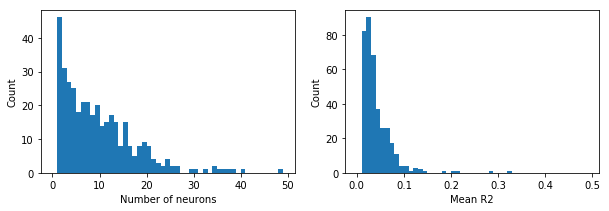

In [31]:
group_counts = np.array([len(x) for x in grouped_data])
group_means = np.array([np.mean(x) for x in grouped_data])

plt.subplots(1,2, figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(group_counts, bins = np.arange(0,50,1))
plt.xlabel('Number of neurons')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(group_means, bins = np.arange(0,0.5,0.01))
plt.xlabel('Mean R2')
plt.ylabel('Count')

In [32]:
f_statistic, p_value = stats.f_oneway(*grouped_data)
f_statistic, p_value

(3.6039440142408434, 1.3490873795696286e-85)

In [38]:
n_shuffle = 10000
shuffle_stats = []
np.random.seed(0)
shuffle_inds = np.arange(thalamus_r2.shape[0], dtype = int)

for i in range(n_shuffle):
    np.random.shuffle(shuffle_inds)
    shuffle_grouped_data = np.zeros((n_x, n_y, n_z), dtype = object)
    for j in range(all_thalamus_inds.shape[0]):
        x, y, z = voxel_inds[j]
        if shuffle_grouped_data[x,y,z] == 0:
            shuffle_grouped_data[x,y,z] = []
        shuffle_grouped_data[x,y,z].append(thalamus_r2[shuffle_inds[j]])
    shuffle_grouped_data = shuffle_grouped_data.reshape(-1)
    shuffle_grouped_data = shuffle_grouped_data[shuffle_grouped_data != 0]

    f,_ = stats.f_oneway(*shuffle_grouped_data)
    shuffle_stats.append(f)


In [39]:
p_value = np.mean(np.array(shuffle_stats) >= f_statistic)
p_value

0.0

(0, 697.2)

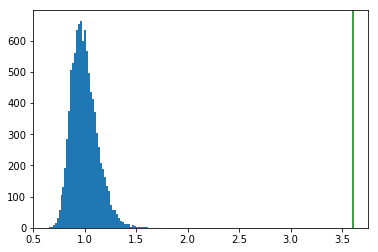

In [40]:
plt.hist(shuffle_stats, bins = 50)
a,b = plt.ylim()
plt.plot([f_statistic, f_statistic], [0,b], 'g-')
plt.ylim([0,b])

In [43]:
def spatial_uniformity_test(value, coordinates, voxel_size = 200, n_shuffle = 1000, rng_seed = 0, return_raw_stats = False):
    '''Nonparametric permutation test against spatial uniformity using f-statistic across voxels for group comparison.'''
    np.random.seed(rng_seed)

    voxel_inds = np.floor(coordinates / voxel_size).astype(int)
    n_x = np.max(voxel_inds[:,0]) + 1
    n_y = np.max(voxel_inds[:,1]) + 1
    n_z = np.max(voxel_inds[:,2]) + 1

    grouped_data = np.zeros((n_x, n_y, n_z), dtype = object)
    for i in range(value.shape[0]):
        x, y, z = voxel_inds[i]
        if grouped_data[x,y,z] == 0:
            grouped_data[x,y,z] = []
        grouped_data[x,y,z].append(value[i])

    grouped_data = grouped_data.reshape(-1)
    grouped_data = grouped_data[grouped_data != 0]

    f_statistic, p_value = stats.f_oneway(*grouped_data)

    shuffle_stats = []
    
    shuffle_inds = np.arange(value.shape[0], dtype = int)

    for i in range(n_shuffle):
        np.random.shuffle(shuffle_inds)
        shuffle_grouped_data = np.zeros((n_x, n_y, n_z), dtype = object)
        for j in range(value.shape[0]):
            x, y, z = voxel_inds[j]
            if shuffle_grouped_data[x,y,z] == 0:
                shuffle_grouped_data[x,y,z] = []
            shuffle_grouped_data[x,y,z].append(value[shuffle_inds[j]])
        shuffle_grouped_data = shuffle_grouped_data.reshape(-1)
        shuffle_grouped_data = shuffle_grouped_data[shuffle_grouped_data != 0]

        f,_ = stats.f_oneway(*shuffle_grouped_data)
        shuffle_stats.append(f)

    p_value = np.mean(np.array(shuffle_stats) >= f_statistic)

    if return_raw_stats:
        return p_value, f_statistic, shuffle_stats
    else:
        return p_value

In [44]:
spatial_uniformity_test(thalamus_r2, thalamus_ccf, voxel_size = 200, n_shuffle = 10000, rng_seed = 0)

0.0

#### Main figure

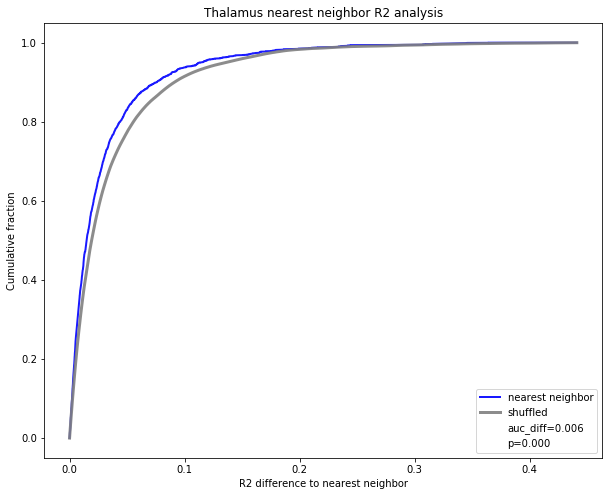

In [87]:
i = len(subregions) - 1
plot_nn_and_shuffle_curves(None, r2_diff_nn_dict[subregions[i]], 
                               np.concatenate(subnuclei_separate_shuffle_r2[subregions[i]]),
                               auc_diff = np.mean(auc_diff[subregions[i]]), p_value = p_values[subregions[i]])
plt.savefig(figfolder + 'thalamus_combined_nn_r2_diff.png', dpi = 300)

## Reviewer figure for spatial noise

In [13]:
class Annotation_from_Coords():
    def __init__(self, datafolder = '../data/', tif_name = 'Annotation_new_10_ds222_32bit.tif', csv_name = 'mousebrainontology_2.csv'):
        self.image_data = self.load_tif_fast(datafolder + tif_name)
        self.df = pd.read_csv(datafolder + csv_name, header = None,names = ['annotation_index', 'annotation'])

    def load_tif_fast(self, file_tif):
        from PIL import Image
        print(f'Loading {file_tif}...')
        # Open the TIF file
        with Image.open(file_tif) as img:
            # Extract image dimensions and frames
            xpix, ypix = img.size
            frames = img.n_frames
            
            # Determine bit depth and data type
            mode_to_bitdepth = {
                'L': 8,    # 8-bit pixels, grayscale
                'P': 8,    # 8-bit pixels, mapped to any other mode using a color palette
                'I;16': 16, # 16-bit pixels, grayscale
                'I;16B': 16, # 16-bit pixels, big endian
                'I': 32,   # 32-bit signed integer pixels
                'F': 32    # 32-bit floating point pixels
            }
            
            bitdepth = mode_to_bitdepth.get(img.mode, None)
            if bitdepth == 32:
                dtype = np.uint32
            elif bitdepth == 16:
                dtype = np.uint16
            elif bitdepth == 8:
                dtype = np.uint8
            else:
                raise ValueError("Unsupported bit depth")
            
            # Initialize empty array to hold image data
            im = np.zeros((ypix, xpix, frames), dtype=dtype)
            
            for i in range(frames):
                img.seek(i)  # Move to the specified frame
                im[:, :, i] = np.array(img)
        
        print('Done loading Tif')
        return im
    
    def get_annotation(self, ccf_ml, ccf_dv, ccf_ap, reso = 20):
        ccf_ml_voxel = np.clip(ccf_ml // reso, 0, self.image_data.shape[0] - 1)
        ccf_dv_voxel = np.clip(ccf_dv // reso, 0, self.image_data.shape[1] - 1)
        ccf_ap_voxel = np.clip(ccf_ap // reso, 0, self.image_data.shape[2] - 1)

        annotation_index = self.image_data[ccf_ml_voxel, ccf_dv_voxel, ccf_ap_voxel]
        if annotation_index == 0:
            return 'Outside CCF'
        if annotation_index in self.df['annotation_index'].values:
            annotation = self.df.loc[self.df['annotation_index'] == annotation_index, 'annotation'].values[0]
        else:
            annotation = 'No annotation'
        return annotation
    
    def get_annot_vec(self, ccf_ml, ccf_dv, ccf_ap, reso = 20):
        ccf_ml_voxel = np.clip(np.array(np.floor(ccf_ml / reso), dtype = np.int), 0, self.image_data.shape[0] - 1)
        ccf_dv_voxel = np.clip(np.array(np.floor(ccf_dv / reso), dtype = np.int), 0, self.image_data.shape[1] - 1)
        ccf_ap_voxel = np.clip(np.array(np.floor(ccf_ap / reso), dtype = np.int), 0, self.image_data.shape[2] - 1)

        annotation_inds = self.image_data[ccf_ml_voxel, ccf_dv_voxel, ccf_ap_voxel]
        annotations = np.full_like(annotation_inds,'No annotation', dtype = 'object')
        annotations[annotation_inds == 0] = 'Outside CCF'

        annotation_dict = dict(zip(self.df['annotation_index'], self.df['annotation']))
        valid_indices = np.isin(annotation_inds, self.df['annotation_index'].values)
        
        annotations[valid_indices] = [annotation_dict[idx] for idx in annotation_inds[valid_indices]]
        return annotations
    

annot = Annotation_from_Coords()

Loading ../data/Annotation_new_10_ds222_32bit.tif...
Done loading Tif


In [14]:
noise_scale = 0
ccf_coords_new = ccf_coords.copy() + np.random.normal(0, noise_scale, ccf_coords.shape)
ccf_labels_new = np.array([annot.get_annotation(ccf_coords[i,1], ccf_coords[i,0], ccf_coords[i,2], reso = 20) for i in range(ccf_coords_new.shape[0])])
np.sum(ccf_labels_new == ccf_labels)

40207

In [15]:
ccf_labels_new2 = annot.get_annot_vec(ccf_coords[:,1], ccf_coords[:,0], ccf_coords[:,2], reso = 20)

In [16]:
np.sum(ccf_labels_new2 == ccf_labels_new)

41284

In [17]:
annot.image_data[[123,12],[12,301],[10,12]]

array([0, 0], dtype=uint32)

In [18]:
noise_scales = [5, 10, 20, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000,2000]
N_reps = 50
noisy_ccf_labels = {}
noisy_ccf_coords = {}

noisy_ccf_labels[0] = [ccf_labels.copy()]
noisy_ccf_coords[0] = [ccf_coords.copy()]

np.random.seed(0)
for i,noise_scale in enumerate(noise_scales):
    print(f'Noise scale: {noise_scale}')
    noisy_ccf_labels[noise_scale] = []
    noisy_ccf_coords[noise_scale] = []
    for j in range(N_reps):

        ccf_coords_new = ccf_coords.copy() + np.random.normal(0, noise_scale, ccf_coords.shape)
        ccf_labels_new = annot.get_annot_vec(ccf_coords_new[:,1], ccf_coords_new[:,0], ccf_coords_new[:,2], reso = 20)

        noisy_ccf_labels[noise_scale].append(ccf_labels_new.copy())
        noisy_ccf_coords[noise_scale].append(ccf_coords_new.copy())


Noise scale: 5
Noise scale: 10
Noise scale: 20
Noise scale: 40
Noise scale: 50
Noise scale: 60
Noise scale: 70
Noise scale: 80
Noise scale: 90
Noise scale: 100
Noise scale: 200
Noise scale: 500
Noise scale: 1000
Noise scale: 2000


In [19]:
save_dict = {'noisy_ccf_labels': noisy_ccf_labels, 'noisy_ccf_coords': noisy_ccf_coords}
pickle.dump(save_dict, open(datafolder + 'noisy_ccf_labels_coords.pkl', 'wb'))


In [20]:
load_dict = pickle.load(open(datafolder + 'noisy_ccf_labels_coords.pkl', 'rb'))

In [21]:
load_dict.keys()

dict_keys(['noisy_ccf_labels', 'noisy_ccf_coords'])

In [22]:
load_dict['noisy_ccf_labels'].keys()

dict_keys([0, 5, 10, 20, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000])

In [23]:
def get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds):
    subregions_annotation_dict = dict()
    for subreg in region_list:
        if subreg == 'ALM':
            continue
        else:
            subregions_annotation_dict[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, subregions_annotation_dict)

    if 'ALM' in region_list:
        use_inds = dict()
        use_inds['ALM'] = alm_inds
        for k,v in inds.items():
            use_inds[k] = np.setdiff1d(v, alm_inds)
        
        return use_inds
    
    return inds

In [24]:
def get_mean_r2_and_fr_for_regions(r2_new, df, ccf_labels, alm_inds, region_list, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 100):

    inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    #delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
    #threshold_inds = np.intersect1d(threshold_inds, delta_inds)

    _inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
    use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}
    use_regions = list(use_inds.keys())

    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    
    r2m, r2sem = func.get_mean_and_sem_for_subregions(r2, use_inds, use_regions)

    frm, frsem = func.get_mean_and_sem_for_subregions(fr, use_inds, use_regions)

    return r2m, r2sem, frm, frsem, use_inds

In [25]:
thalamus_use_nuclei = [
    #'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    #'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    #'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    #'Paraventricular nucleus of the thalamus', #PVN
    #'Reticular nucleus of the thalamus', #RT
    #'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

In [26]:
noise_scales = list(load_dict['noisy_ccf_labels'].keys())

r2_means = [[] for i in range(len(noise_scales))]
r2_sems = [[] for i in range(len(noise_scales))]
fr_means = [[] for i in range(len(noise_scales))]
fr_sems = [[] for i in range(len(noise_scales))]
n_neurons = [[] for i in range(len(noise_scales))]
r2_diff_nn_distributions = [[] for i in range(len(noise_scales))]

for i,noise_scale in enumerate(noise_scales):

    if i == 0:
        _ccf_coords = load_dict['noisy_ccf_coords'][noise_scale][0]
        _ccf_labels = load_dict['noisy_ccf_labels'][noise_scale][0]

        r2_mean, r2_sem, fr_mean, fr_sem, use_inds = get_mean_r2_and_fr_for_regions(r2_new, df, _ccf_labels, alm_inds, thalamus_use_nuclei, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 1)
        r2_means[i].append(r2_mean)
        r2_sems[i].append(r2_sem)
        fr_means[i].append(fr_mean)
        fr_sems[i].append(fr_sem)
        n_neurons[i].append([v.shape[0] for v in use_inds.values()])
        _r2_dict = {}
        for k,v in use_inds.items():
            _r2_dict[k] = func.get_NN_r2_dist(r2_new['5_0']['response_r2'], _ccf_coords, v)
        r2_diff_nn_distributions[i].append(np.concatenate(list(_r2_dict.values())))

    else:
        for j in range(len(load_dict['noisy_ccf_labels'][noise_scale])):

            _ccf_labels = load_dict['noisy_ccf_labels'][noise_scale][j]
            _ccf_coords = load_dict['noisy_ccf_coords'][noise_scale][j]

            r2_mean, r2_sem, fr_mean, fr_sem, use_inds = get_mean_r2_and_fr_for_regions(r2_new, df, _ccf_labels, alm_inds, thalamus_use_nuclei, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 1)
            r2_means[i].append(r2_mean)
            r2_sems[i].append(r2_sem)
            fr_means[i].append(fr_mean)
            fr_sems[i].append(fr_sem)
            n_neurons[i].append([v.shape[0] for v in use_inds.values()])
            _r2_dict = {}
            for k,v in use_inds.items():
                _r2_dict[k] = func.get_NN_r2_dist(r2_new['5_0']['response_r2'], _ccf_coords, v)
            r2_diff_nn_distributions[i].append(np.concatenate(list(_r2_dict.values())))

In [27]:
len(noise_scales)

15

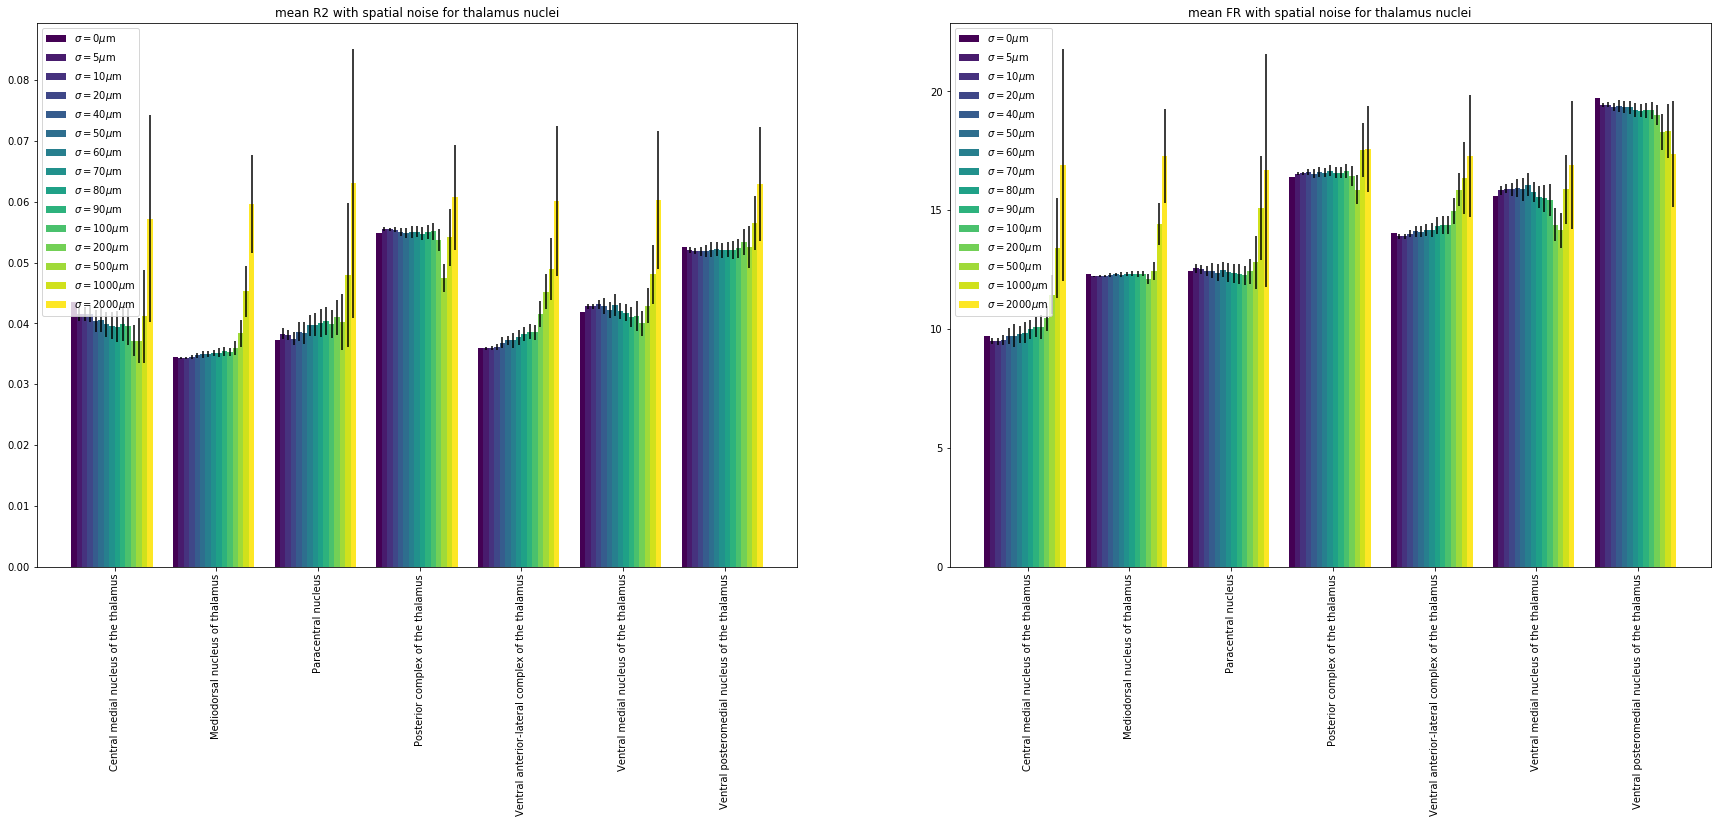

In [28]:
plt.subplots(1,2, figsize = (30,10))
colors = plt.cm.viridis(np.linspace(0,1,len(noise_scales)))

plt.subplot(1,2,1)
plt.title('mean R2 with spatial noise for thalamus nuclei')
for i in range(len(noise_scales)):
    plt.bar(np.arange(len(thalamus_use_nuclei))-0.4+0.8/len(noise_scales)*i, np.mean(np.array(r2_means[i]), axis = 0), width=0.8/len(noise_scales), yerr = np.std(np.array(r2_means[i]), axis = 0), color = colors[i], label = r'$\sigma=%.0f \mu$m'%noise_scales[i])
plt.xticks(np.arange(len(thalamus_use_nuclei)), thalamus_use_nuclei, rotation = 90)
plt.legend()

plt.subplot(1,2,2)
plt.title('mean FR with spatial noise for thalamus nuclei')
for i in range(len(noise_scales)):
    plt.bar(np.arange(len(thalamus_use_nuclei))-0.4+0.8/len(noise_scales)*i, np.mean(np.array(fr_means[i]), axis = 0), width=0.8/len(noise_scales), yerr = np.std(np.array(fr_means[i]), axis = 0), color = colors[i], label = r'$\sigma=%.0f \mu$m'%noise_scales[i])
plt.xticks(np.arange(len(thalamus_use_nuclei)), thalamus_use_nuclei, rotation = 90)
plt.legend()

#plt.savefig(figfolder + 'spatial_noise_barplot_50reps.png', dpi = 300, bbox_inches = 'tight')

In [44]:
fig4.nn_r2_diff['subnuclei_separate_shuffle_r2'].keys()

dict_keys(['Central nucleus', 'Mediodorsal nucleus of thalamus', 'Paracentral nucleus', 'Posterior complex of the thalamus', 'Ventral anterior-lateral complex of the thalamus', 'Ventral medial nucleus of the thalamus', 'Ventral posterior complex of the thalamus', 'combined'])

(0.7, 0.9)

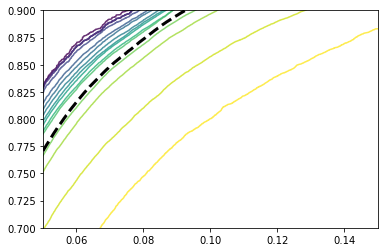

In [30]:
for i in range(len(noise_scales)):
    r2_nn_list = r2_diff_nn_distributions[i]
    r2_combined = np.concatenate(r2_nn_list)
    plt.plot(np.sort(r2_combined), np.linspace(0,1,len(r2_combined)), color = colors[i], alpha = 0.8)
r2_shuffle = np.concatenate(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2']['combined'])
plt.plot(np.sort(r2_shuffle), np.linspace(0,1,len(r2_shuffle)), color = 'k',linestyle = '--', alpha = 1, lw = 3)
plt.xlim(0.05,0.15)
plt.ylim(0.7,0.9)



In [46]:
fig4.nn_r2_diff.keys()

dict_keys(['subnuclei_separate_nn_r2', 'subnuclei_separate_shuffle_r2'])

In [52]:
nn_auc = {}
shuffle_auc = {}
auc_diff = {}
p_values = {}

for k,v in fig4.nn_r2_diff['subnuclei_separate_nn_r2'].items():
    nn_sorted = np.sort(v)
    max_nn_r2 = nn_sorted[-1]
    nn_cdf = np.linspace(0,1,nn_sorted.shape[0])
    nn_auc[k] = func.calculate_auc(nn_sorted, nn_cdf)

    auc_diff[k] = []
    for i in range(N_shuffle):
        shuffle_sorted = np.sort(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2'][k][i])
        shuffle_cdf = np.linspace(0,1, shuffle_sorted.shape[0])
        max_shuffle_r2 = shuffle_sorted[-1]

        if max_shuffle_r2 > max_nn_r2:
            _nn_sorted = np.append(nn_sorted,[max_shuffle_r2])
            _nn_cdf = np.append(nn_cdf, [1])
            _shuffle_sorted = shuffle_sorted
            _shuffle_cdf = shuffle_cdf

        else:
            _nn_sorted = nn_sorted
            _nn_cdf = nn_cdf
            _shuffle_sorted = np.append(shuffle_sorted,[max_nn_r2])
            _shuffle_cdf = np.append(shuffle_cdf, [1])

        auc_diff[k].append(func.calculate_auc(_nn_sorted, _nn_cdf) - func.calculate_auc(_shuffle_sorted, _shuffle_cdf))

    p_values[k] = np.sum(np.array(auc_diff[k]) <= 0) / N_shuffle

p_values


{'Central nucleus': 0.002,
 'Mediodorsal nucleus of thalamus': 0.0,
 'Paracentral nucleus': 0.0,
 'Posterior complex of the thalamus': 0.0,
 'Ventral anterior-lateral complex of the thalamus': 0.197,
 'Ventral medial nucleus of the thalamus': 0.0,
 'Ventral posterior complex of the thalamus': 0.0,
 'combined': 0.0}

### Shuffle for three large subregions

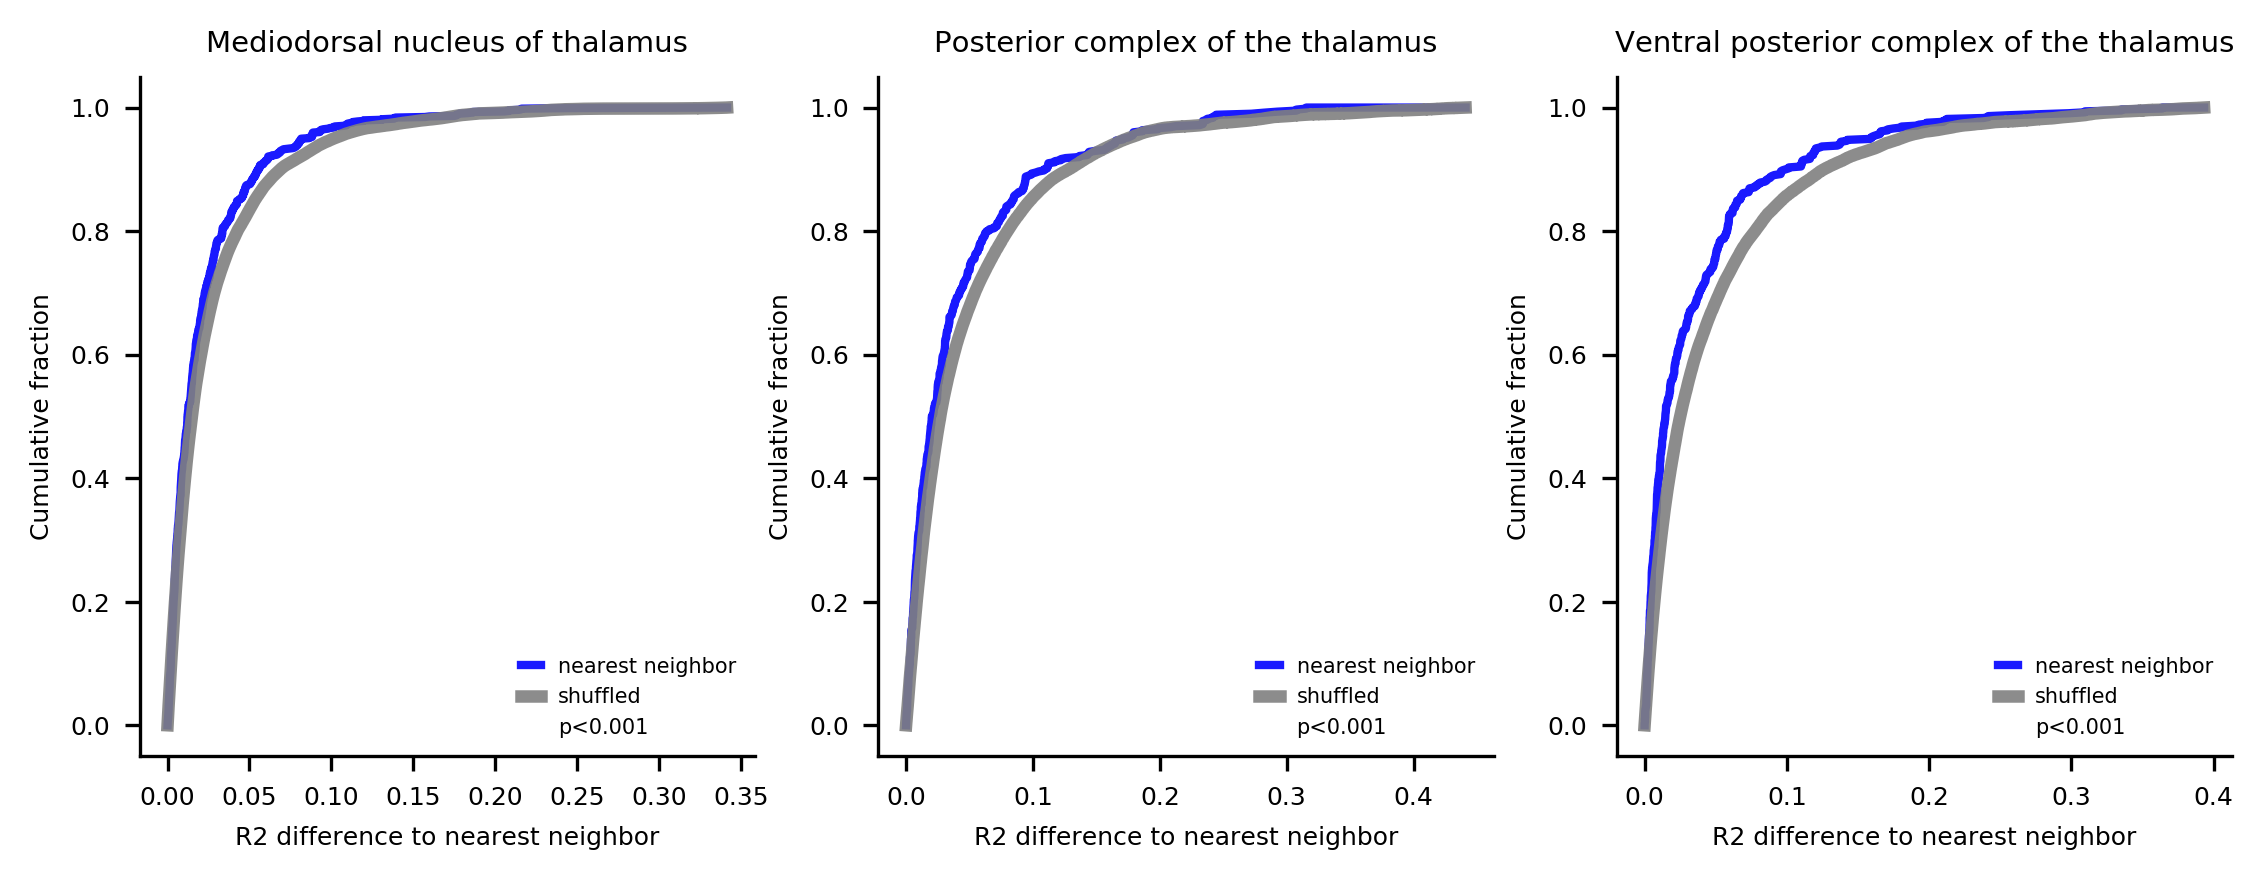

In [57]:
subregions = ['Mediodorsal nucleus of thalamus', 'Posterior complex of the thalamus', 'Ventral posterior complex of the thalamus']
N_plots = 3
f, ax = plt.subplots(1, 3, figsize=(3 * N_plots, 3))


for i in range(len(subregions)):
    plot_nn_and_shuffle_curves(ax[i], fig4.nn_r2_diff['subnuclei_separate_nn_r2'][subregions[i]], 
                               np.concatenate(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2'][subregions[i]]),
                               titlestr = subregions[i],
                               )
    ax[i].plot([],[],' ',label='p<0.001' if p_values[subregions[i]] < 0.001 else 'p=%0.3f'%p_values[subregions[i]])
    ax[i].legend()

plt.savefig(figfolder + 'thalamus_subnuclei_nn_r2_dif_select_subregions.png', dpi = 300, bbox_inches = 'tight')

### Spatial noise for nearest neighbors

In [31]:
N_shuffle = len(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2']['combined'])

In [32]:
nn_auc = {}
auc_diff = {}
p_values = {}

for i,noise_scale in enumerate(noise_scales):
    r2_nn_list = r2_diff_nn_distributions[i]
    r2_combined = np.concatenate(r2_nn_list)
    nn_sorted = np.sort(r2_combined)
    max_nn_r2 = nn_sorted[-1]
    nn_cdf = np.linspace(0,1,nn_sorted.shape[0])
    nn_auc[noise_scale] = func.calculate_auc(nn_sorted, nn_cdf)

    auc_diff[noise_scale] = []
    for i in range(N_shuffle):
        shuffle_sorted = np.sort(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2']['combined'][i])
        shuffle_cdf = np.linspace(0,1, shuffle_sorted.shape[0])
        max_shuffle_r2 = shuffle_sorted[-1]

        if max_shuffle_r2 > max_nn_r2:
            _nn_sorted = np.append(nn_sorted,[max_shuffle_r2])
            _nn_cdf = np.append(nn_cdf, [1])
            _shuffle_sorted = shuffle_sorted
            _shuffle_cdf = shuffle_cdf

        else:
            _nn_sorted = nn_sorted
            _nn_cdf = nn_cdf
            _shuffle_sorted = np.append(shuffle_sorted,[max_nn_r2])
            _shuffle_cdf = np.append(shuffle_cdf, [1])

        auc_diff[noise_scale].append(func.calculate_auc(_nn_sorted, _nn_cdf) - func.calculate_auc(_shuffle_sorted, _shuffle_cdf))

    p_values[noise_scale] = np.sum(np.array(auc_diff[noise_scale]) <= 0) / N_shuffle

p_values

{0: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 100: 0.003,
 200: 0.912,
 500: 1.0,
 1000: 1.0,
 2000: 1.0}

In [ ]:
import VideoAnalysisUtils.plot_style as style

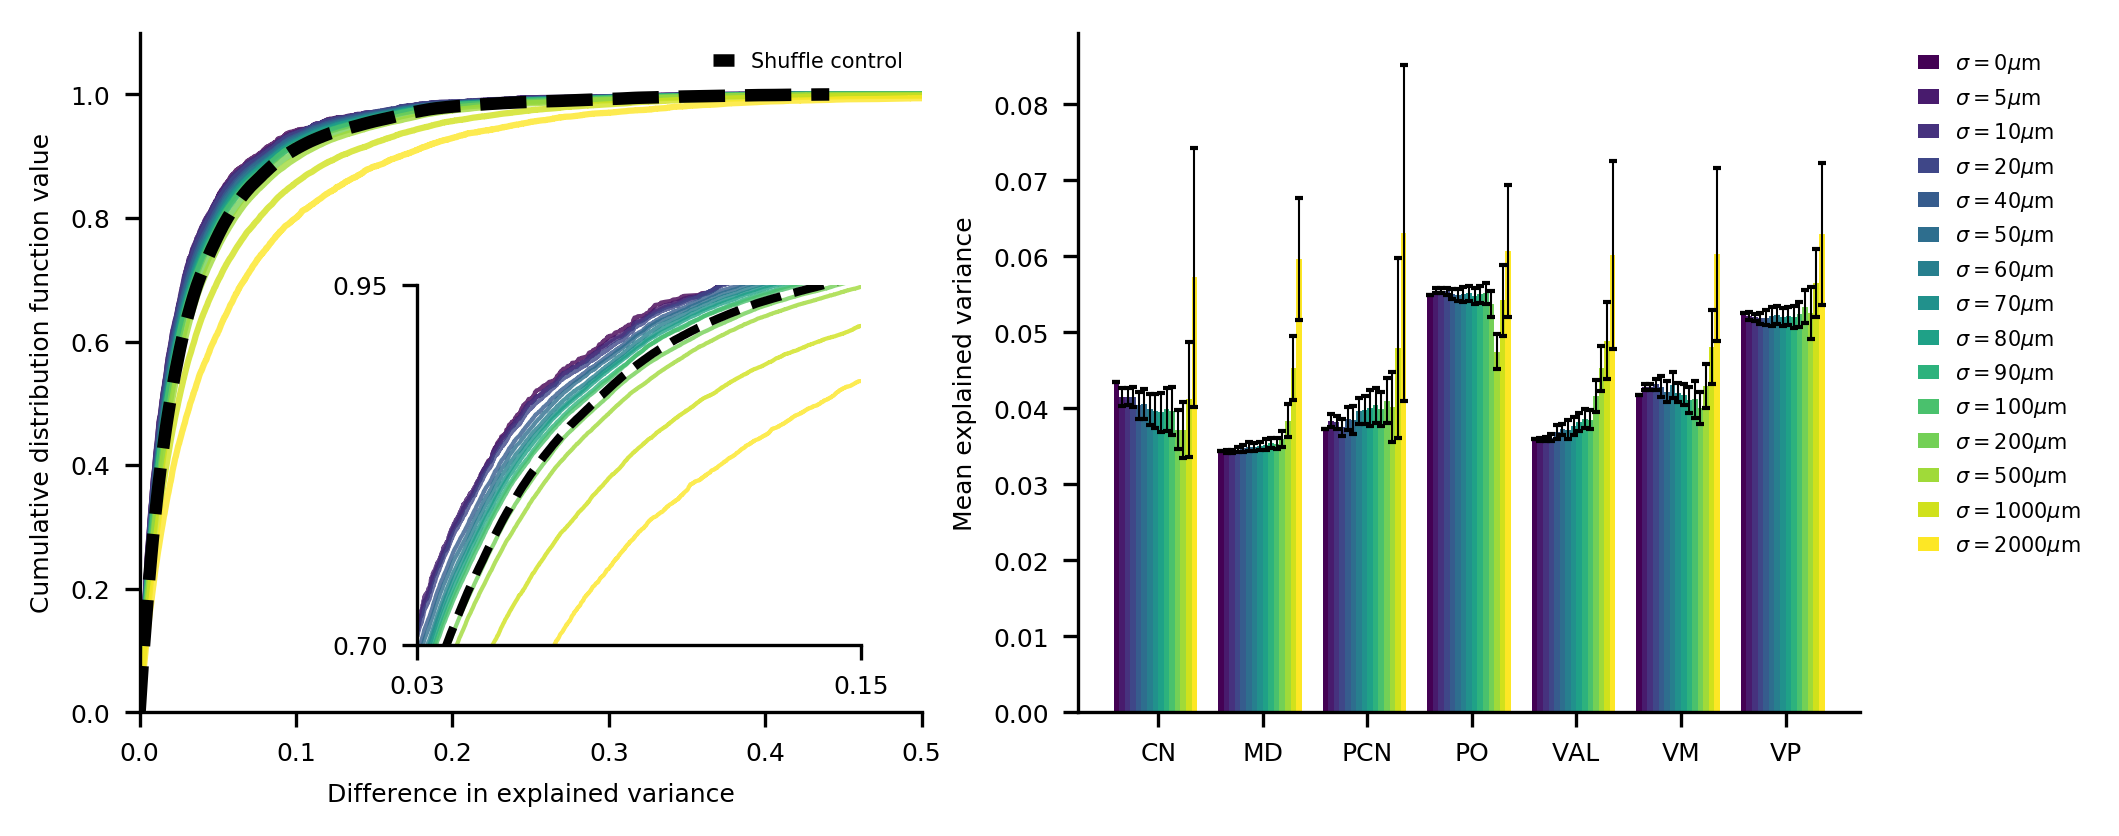

In [36]:
fig, axs = plt.subplots(1,2, figsize = (7.4,3))

for i in range(len(noise_scales)):
    r2_nn_list = r2_diff_nn_distributions[i]
    r2_combined = np.concatenate(r2_nn_list)
    axs[0].plot(np.sort(r2_combined), np.linspace(0,1,len(r2_combined)), color = colors[i], alpha = 0.8)
r2_shuffle = np.concatenate(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2']['combined'])
axs[0].plot(np.sort(r2_shuffle), np.linspace(0,1,len(r2_shuffle)), color = 'k',linestyle = '--', alpha = 1, lw = 3, label = 'Shuffle control')
axs[0].set_xlim(0.0,0.5)
axs[0].set_ylim(0.,1.1)
axs[0].legend()
axs[0].set_xlabel('Difference in explained variance')
axs[0].set_ylabel('Cumulative distribution function value')

inset_ax = fig.add_axes([0.25, 0.2, 0.2, 0.4])
for i in range(len(noise_scales)):
    r2_nn_list = r2_diff_nn_distributions[i]
    r2_combined = np.concatenate(r2_nn_list)
    inset_ax.plot(np.sort(r2_combined), np.linspace(0,1,len(r2_combined)), color = colors[i], alpha = 0.8, lw = 1)
r2_shuffle = np.concatenate(fig4.nn_r2_diff['subnuclei_separate_shuffle_r2']['combined'])
inset_ax.plot(np.sort(r2_shuffle), np.linspace(0,1,len(r2_shuffle)), color = 'k',linestyle = '--', alpha = 1, lw = 2)
inset_ax.set_xlim(0.03,0.15)
inset_ax.set_ylim(0.7,0.95)
inset_ax.set_xticks([0.03,0.15])
inset_ax.set_yticks([0.7,0.95])



for i in range(len(noise_scales)):
    axs[1].bar(np.arange(len(thalamus_use_nuclei))-0.4+0.8/len(noise_scales)*i, 
               np.mean(np.array(r2_means[i]), axis = 0), 
               width=0.8/len(noise_scales), 
               yerr = np.std(np.array(r2_means[i]), axis = 0), 
               color = colors[i], 
               label = r'$\sigma=%.0f \mu$m'%noise_scales[i],
               capsize = 1,
               error_kw={'elinewidth': .5})
axs[1].set_xticks(np.arange(len(thalamus_use_nuclei)))
axs[1].set_xticklabels(fig4.short_names_correct_allen, rotation = 0)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_ylabel('Mean explained variance')

plt.savefig(figfolder + 'spatial_noise_thalamic_subnuclei.png', dpi = 300, bbox_inches = 'tight')

### Miscellaneous spatial noise plots

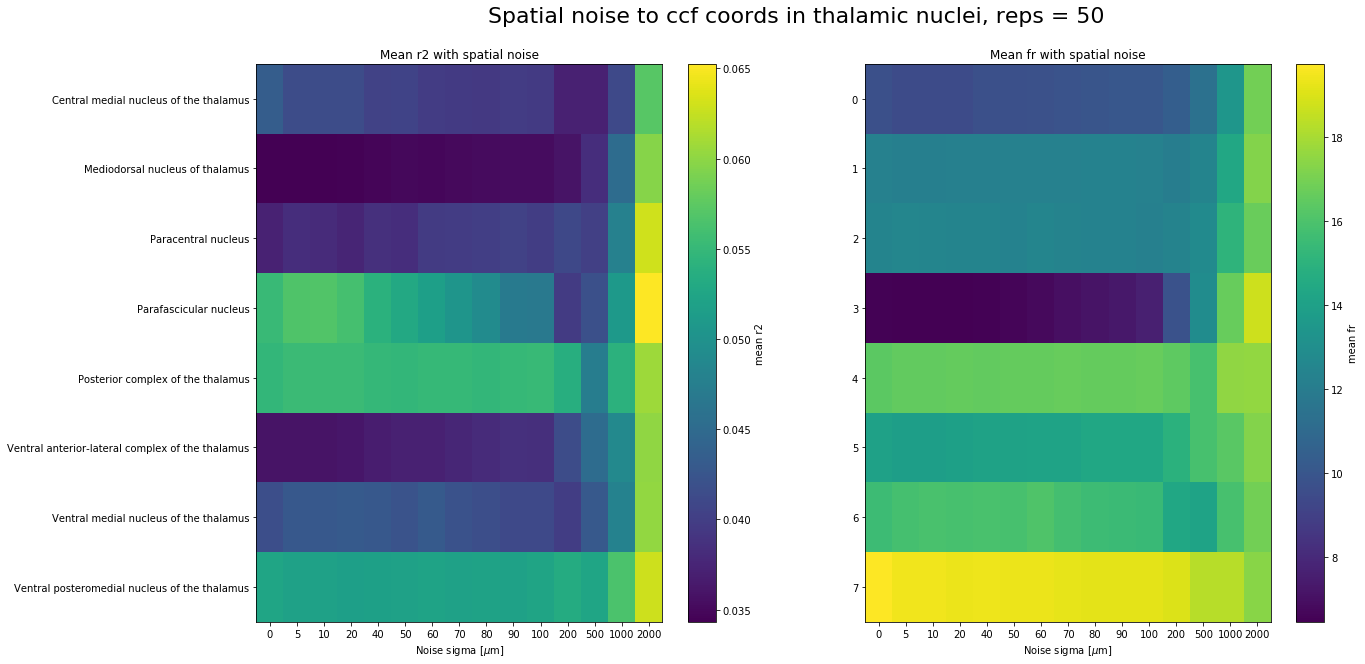

In [85]:
f,_ = plt.subplots(1,2, figsize = (20,10))
f.suptitle('Spatial noise to ccf coords in thalamic nuclei, reps = 50', fontsize = 22)

plt.subplot(1,2,1)
plt.title('Mean r2 with spatial noise')
plt.imshow(np.array([np.mean(np.array(_reps), axis = 0) for _reps in r2_means]).T, aspect = 'auto')
plt.colorbar(label = 'mean r2')
plt.xticks(np.arange(0,len(noise_scales)), noise_scales)
plt.xlabel(r'Noise sigma [$\mu$m]')
plt.yticks(np.arange(0,len(use_inds.keys())), use_inds.keys(), rotation = 0)

plt.subplot(1,2,2)
plt.title('Mean fr with spatial noise')
plt.imshow(np.array([np.mean(np.array(_reps), axis = 0) for _reps in fr_means]).T, aspect = 'auto')
plt.colorbar(label = 'mean fr')
plt.xticks(np.arange(0,len(noise_scales)), noise_scales)
plt.xlabel(r'Noise sigma [$\mu$m]')

plt.subplots_adjust(top=0.9)
plt.savefig(figfolder + 'spatial_noise_heatmap_50reps.png', dpi = 300, bbox_inches = 'tight')

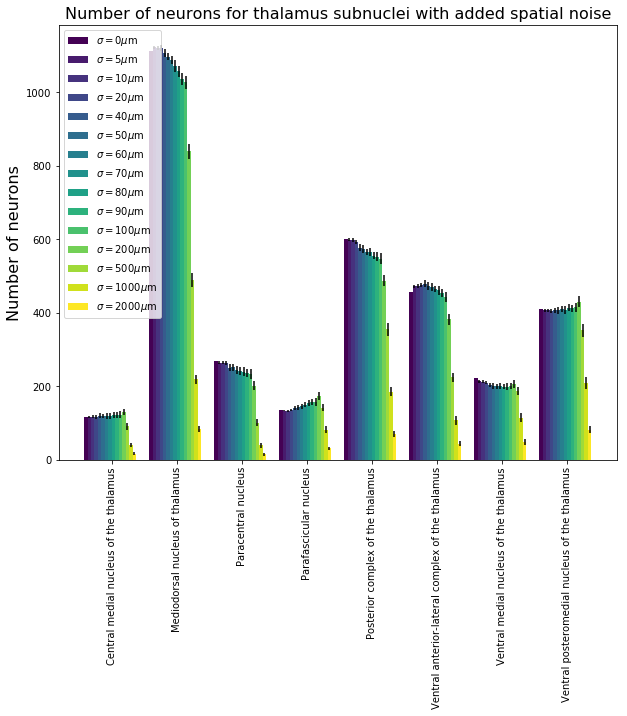

In [23]:
plt.figure(figsize = (10,8))
plt.title('Number of neurons for thalamus subnuclei with added spatial noise', fontsize = 16)

colors = plt.cm.viridis(np.linspace(0,1,len(noise_scales)))

for i in range(len(noise_scales)):
    plt.bar(np.arange(len(thalamus_use_nuclei))-0.4+0.8/len(noise_scales)*i, np.mean(np.array(n_neurons[i]), axis = 0), width=0.8/len(noise_scales), yerr = np.std(np.array(n_neurons[i]), axis = 0), color = colors[i],label = r'$\sigma=%.0f \mu$m'%noise_scales[i])
plt.xticks(np.arange(len(thalamus_use_nuclei)), thalamus_use_nuclei, rotation = 90)
plt.ylabel('Number of neurons', fontsize = 16)
plt.legend()
plt.savefig(figfolder + 'spatial_noise_n_neurons_50reps.png', dpi = 300, bbox_inches = 'tight')